# Lab 3: Regularized Least Square
#teamwork: Somayyeh Eslami, Maryam Bagherirad
#In this lab, we focus on RLS to address linear regression problems. 

In this lab, we have to:
- **(Task 1)** implement RLS to solve linear regression problems
- **(Task 2)** observe performance of RLS changing the noise in the data and the regularization parameter
- **(Task 3)** implement K-Fold Cross-Validation algorithm for RLS


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

## Data generation
To generate linear regression data, we use the `linearRegrFunction` introduced in Lab0.

In [37]:
def linearRegrFunction(n, D, low_D, high_D, W, sigma_noise):
    X = np.zeros((n,D))
    for i in range(0, D):
        X[:,i] = np.random.uniform(low_D[i], high_D[i], size=n)
    
    gauss_noise = np.random.normal(0, sigma_noise, size=(n,1))

    Y = np.dot(X, W) + gauss_noise
    
    return X, Y 

### Example: Noiseless dataset


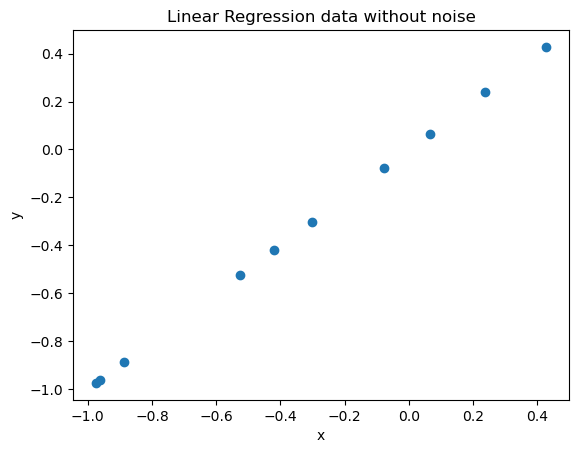

In [40]:
n = 10
D = 1
low_D, high_D = [-1], [1]
w = np.array(1.0).reshape(1, 1)
noise_std = 0.0

# Data generation
X, Y = linearRegrFunction(n, D, low_D, high_D, w, noise_std)

# Plot of the data
_, ax = plt.subplots()
ax.set_title("Linear Regression data without noise")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.scatter(X, Y)

## Task 1: RLS regressor
We want to implement the `regularizedLSTrain` function which train RLS regression.

The signature of `regularizedLSTrain` is the following:

`w = regularizedLSTrain(Xtr, Ytr, lam)`

where:
- **Xtr** are the training inputs
- **Ytr** are the training outputs
- **lam** is the regularization parameter $\lambda$

To implement this function, you will need to use the following functions from numpy:

- [`np.linalg.cholesky`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.cholesky.html)
- [`scipy.linalg.solve_triangular`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_triangular.html)

Consider 

**$(X_{tr}^\intercal X_{tr} + \lambda n I)w = X_{tr}^\intercal Y_{tr}$**

Let $A = X_{tr}^\intercal X_{tr} + \lambda n I$ and $b = X_{tr}^\intercal Y_{tr}$, we can find $w$ with the following steps:
1. First build the left-hand side matrix `A`, and the right-hand side matrix `b`.
2. Compute the Cholesky decomposition of `A` (note that the numpy function will provide a lower-triangular matrix)
3. You will have to solve two triangular systems, one using the Cholesky decomposition, and the other using its transpose.

In [43]:
import numpy as np
from scipy.linalg import solve_triangular

def regularizedLSTrain(Xtr, Ytr, lam):
    # Number of samples
    n = Xtr.shape[0]
    
    # Step 1: Build A and b
    A = Xtr.T @ Xtr + lam * n * np.eye(Xtr.shape[1])
    b = Xtr.T @ Ytr
    
    # Step 2: Compute Cholesky decomposition of A
    L = np.linalg.cholesky(A)
    
    # Step 3: Solve L * y = b for y (using forward substitution)
    y = solve_triangular(L, b, lower=True)
    
    # Step 4: Solve L.T * w = y for w (using backward substitution)
    w = solve_triangular(L.T, y, lower=False)
    
    return w


We need also to implement a function `regularizedLSTest` which given a test set `Xte` and the `w` obtained using `regularizedLSTrain`, it returns `Ypred` containing the predictions

In [46]:
def regularizedLSTest(w, Xte):
    # Calculate predictions for the test set
    Ypred = Xte @ w
    return Ypred


To evaluate the performance of RLS regressor, we need a function to estimate the error.

Given two vectors `Ytrue` (real outputs) and `Ypred` (predicted outputs), we can measure the error obtained when predicting `Ypred` instead of `Ytrue` with the MSE (Mean Square Error)

In [52]:
def calcError(Ypred, Ytrue):
    return np.mean((Ypred-Ytrue)**2)

Now we can build an easy example to observe how our model works:
- Generate a training set with **ntrain** points and a test set with **ntest** points 
- Train RLS with `regularizedLSTrain` function and test it with `regularizedLSTest` on test set
- Compute the training and test error 

In [55]:
ntrain = 100
ntest = 50
D = 1
low_D = [-1] * D
high_D = [5] * D
rnd_state = np.random.RandomState(42)
wtrue = rnd_state.randn(D, 1) 
noise_std = 0.1

lam = 1e-3

# Generate a training set with ntrain points and a test set with ntest 
Xtr, Ytr = linearRegrFunction(ntrain, D, low_D, high_D, wtrue, noise_std)
Xte, Yte = linearRegrFunction(ntest, D, low_D, high_D, wtrue, noise_std)

# Train RLS
w = w = regularizedLSTrain(Xtr, Ytr, lam)

# Compute predictions on training and test set
Ytr_pred = regularizedLSTest(w, Xtr)
Yte_pred = regularizedLSTest(w, Xte)


train_err = calcError(Ytr_pred, Ytr)
test_err = calcError(Yte_pred, Yte)


print("[--] Training error: {}\tTest error: {}".format(train_err, test_err))

[--] Training error: 0.009228697497127666	Test error: 0.011707125046497931


## Task 2: Changing $\lambda$
Now we can play with our model changing the noise level in the data and changing the $\lambda$ parameter.

Let's start by changing $\lambda$ and fixing the other parameters.

<>:42: SyntaxWarning: invalid escape sequence '\l'
<>:42: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Somayyeh\AppData\Local\Temp\ipykernel_6044\2752713563.py:42: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel("$\lambda$")


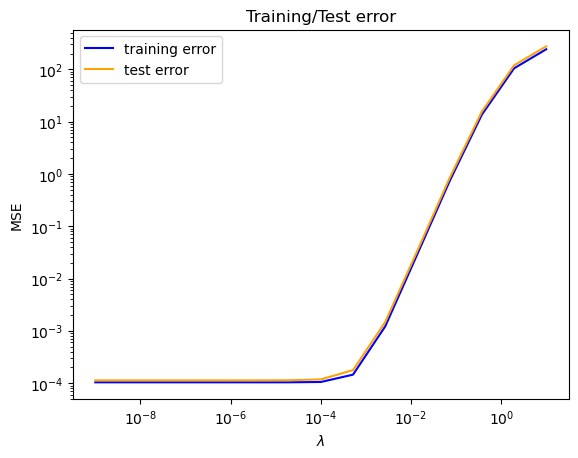

In [58]:
ntrain = 500
ntest = 100
D = 2
low_D = [-2] * D
high_D = [2] * D
w_true = np.array([i for i in range(D)]).reshape(D, 1) + 10
noise_std = 0.01


# Data generation
Xtr, Ytr = linearRegrFunction(ntrain, D, low_D, high_D, w_true, noise_std)
Xte, Yte = linearRegrFunction(ntest, D, low_D, high_D, w_true, noise_std)


lam_list = np.logspace(-9, 1, 15)
tr_err = []
te_err = []

for lam in lam_list:
        
# Train RLS model
    w = regularizedLSTrain(Xtr, Ytr, lam)
    
    # Compute predictions on training and test sets
    Ytr_pred = regularizedLSTest(w, Xtr)
    Yte_pred = regularizedLSTest(w, Xte)
    
    # Compute training and test error and store them
    train_error = calcError(Ytr_pred, Ytr)
    test_error = calcError(Yte_pred, Yte)
    
    tr_err.append(train_error)
    te_err.append(test_error)


# Plot training and test error
_, ax = plt.subplots()
ax.set_title("Training/Test error")
ax.plot(lam_list, tr_err, '-', c="blue", label="training error")
ax.plot(lam_list, te_err, '-', c="orange", label="test error")
ax.legend(loc="best")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.set_xscale("log")
ax.set_yscale("log")


### Explain here what happens when $\lambda$ increases:  
As we increase 
λ, we actually increase the strength of regularization for the RLS model. For the most part, here's what tends to happen :

Higher Bias - Underfitting:

A  
????
λ punishes large weights by shrinking them toward zero. Thus, a model now becomes much simpler and less flexible since it cannot fit the training data data quite as well.
While this may have a consequence of increased training error since the model starts underfitting by not capturing all patterns in the training data.
Reduced Variance - Improved Generalization:

Large es of 
????
λ prevent the model from fitting the noise in the training data. Therefore, the higher the value, the more robust and resilient to overfitting a model is made.
The test error therefore goes down in the  eginning since
For large enough values of λ this optimum is reached where the model generalizes well. If this value is exceeded, the test errors increase again on account of underfitting.
U-Shaped Error Curves:

The training error and test error often both have a U shape with respect to λ: initially the test error is high for small values of λ because of overfitting and the training error is low, but as λ increases the test error drops while the training error rises. Eventually if λ is too high,
Where λ becomes too large, training and test errors start increasing due to underfitting.
 Inry, increasing 
????
λ makes the model simpler and more robust against overfitting, but beyond a certain point, it leads to underfitting where the model becomes too rigid to capture the underlying trends in the data. The goal  find an optimal 
????
λ where the test error is minimized.

## Task 3: K-Fold Cross Validation for RLS
Now, we want to implement the K-Fold Cross Validation for RLS. 

In specific we want to implement the `KFoldCVRLS` function which, given a training set **Xtr** and **Ytr**, a number of folds **KF** and a set of values for $\lambda$ (**regpar_list**) and returns the $\lambda$ which minimize the average validation error **bestlam**, the mean validation error **val_mean**, the validation error variance **val_var**, the mean training error **tr_mean** and the training error variance **tr_var**.

`bestlam, val_mean, val_var, tr_mean, tr_var = KFoldCVRLS(Xtr, Ytr, KF, regpar_list)`

**Hint:** this function is very similar to K-Fold Cross-Validation algorithm for KNN (Lab1)

In [63]:
def KFoldCVRLS(Xtr, Ytr, KF, regpar_list):
    if KF <= 1:
        raise Exception("Please supply a number of fold > 1")

    # Ensures that regpar_list is a numpy array
    regpar_list = np.array(regpar_list)
    num_regpar = regpar_list.size

    n_tot = Xtr.shape[0]
    n_val = int(n_tot // KF)

    # We want to compute 1 error for each `k` and each fold
    tr_errors = np.zeros((num_regpar, KF))
    val_errors = np.zeros((num_regpar, KF))

    for idx, regpar in enumerate(regpar_list):
        # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
        rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
        split_idx = np.array_split(rand_idx, KF)
        for fold in range(KF):
            # Set the indices in boolean mask for all validation samples to `True`
            val_mask = np.zeros(n_tot, dtype=bool)
            val_mask[split_idx[fold]] = True

            # Use the boolean mask to split X, Y in training and validation part

             # Split data into training and validation sets
            X = Xtr[~val_mask]
            Y = Ytr[~val_mask]
            X_val = Xtr[val_mask]
            Y_val = Ytr[val_mask]
            
            # Train the RLS model on the training set
            currW = regularizedLSTrain(X, Y, regpar)
            
            # Compute training error
            YpredTR = regularizedLSTest(currW, X)
            tr_errors[idx, fold] = calcError(YpredTR, Y)

            # Compute validation error
            YpredVAL = regularizedLSTest(currW, X_val)
            val_errors[idx, fold] = calcError(YpredVAL, Y_val)

    # Calculate error statistics along the repetitions
    tr_mean = np.mean(tr_errors, axis=1)
    tr_var = np.var(tr_errors, axis=1)
    val_mean = np.mean(val_errors, axis=1)
    val_var = np.var(val_errors, axis=1)
    
    bestlam_idx = np.argmin(val_mean)
    bestlam = regpar_list[bestlam_idx]

    return bestlam, val_mean, val_var, tr_mean, tr_var

Use `KFoldCVRLS` to find the best regularization parameter 

<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Somayyeh\AppData\Local\Temp\ipykernel_6044\1101178414.py:23: SyntaxWarning: invalid escape sequence '\l'
  ax.axvline(bestlam, linestyle="--", c="red", alpha=0.7, label="best $\lambda$")
C:\Users\Somayyeh\AppData\Local\Temp\ipykernel_6044\1101178414.py:25: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel("$\lambda$")


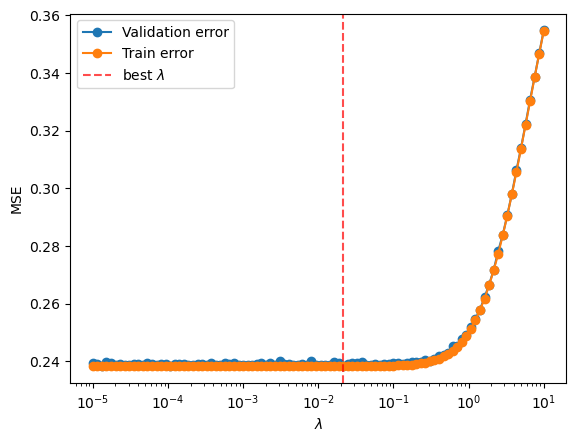

In [68]:
n = 1000
D = 1
sigma_noise = 0.5
truew = np.random.randn(D, 1)
reg_pars = np.logspace(-5, 1, 100)
KF = 5

low_D = [-3] * D
high_D = [3] * D

# Generate training set
Xtr, Ytr =  linearRegrFunction(n, D, low_D, high_D, truew, sigma_noise)


# Compute best lambda
bestlam, Vm, Vs, Tm, Ts = KFoldCVRLS(Xtr, Ytr, KF, reg_pars)


# Plot training and validation error
_, ax = plt.subplots()
ax.plot(reg_pars, Vm, '-o', label="Validation error")
ax.plot(reg_pars, Tm, '-o', label="Train error")
ax.axvline(bestlam, linestyle="--", c="red", alpha=0.7, label="best $\lambda$")
ax.set_xscale("log")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.legend(loc="best")

Plot the regression curve using the best $\lambda$ (found with `KFoldCVRLS`) and using the worsk $\lambda$

[--] best lambda found: 0.021544346900318846


<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Somayyeh\AppData\Local\Temp\ipykernel_6044\2545491432.py:11: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(Xtr, Ypred_best, '-',c="red", label="with best $\lambda$")
C:\Users\Somayyeh\AppData\Local\Temp\ipykernel_6044\2545491432.py:12: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(Xtr, Ypred_worst, '-',c="black", label="with worst $\lambda$")


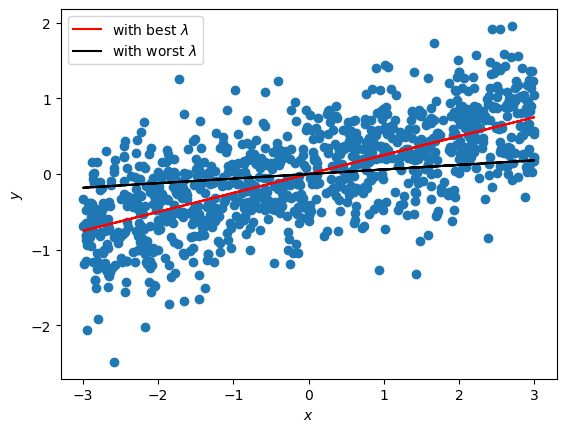

In [70]:
worst_lam = 10
print("[--] best lambda found: {}".format(bestlam))
w_best = regularizedLSTrain(Xtr, Ytr, bestlam)
Ypred_best = regularizedLSTest(w_best, Xtr)
w_worst = regularizedLSTrain(Xtr, Ytr, worst_lam)
Ypred_worst = regularizedLSTest(w_worst, Xtr)


_, ax = plt.subplots()
ax.scatter(Xtr, Ytr)
ax.plot(Xtr, Ypred_best, '-',c="red", label="with best $\lambda$")
ax.plot(Xtr, Ypred_worst, '-',c="black", label="with worst $\lambda$")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.legend(loc="best")

Use the best $\lambda$ found to train the model on the full training set and compute the test error on the following test set.   

In [72]:
Xte, Yte = linearRegrFunction(200, D, low_D, high_D, truew, sigma_noise)

print("[--] best lambda found: {}".format(bestlam))

# Insert your code here
w_best = regularizedLSTrain(Xtr, Ytr, bestlam)
Ypred_best = regularizedLSTest(w_best, Xte)
test_err = calcError(Ypred_best, Yte)

print("[--] Test error: {}".format(test_err))

[--] best lambda found: 0.021544346900318846
[--] Test error: 0.22924732554254035


### Repeat the procedure on a different dataset

Create new training **and** test datasets, sampled in a non-symmetric range (for example you can set the `low_D` and `high_D` parameters of the `linearRegrFunction` function to 2 and 5).

Then repeat the K-fold CV procedure, and check whether the best regularization parameter changes!

<>:33: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\l'
<>:33: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Somayyeh\AppData\Local\Temp\ipykernel_6044\1088375744.py:33: SyntaxWarning: invalid escape sequence '\l'
  ax.axvline(bestlam, linestyle="--", color="red", alpha=0.7, label="Best $\lambda$")
C:\Users\Somayyeh\AppData\Local\Temp\ipykernel_6044\1088375744.py:35: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel("$\lambda$")


[--] Best lambda found on new dataset: 0.0008697490026177834
[--] Test error on new dataset: 0.2637108307613144


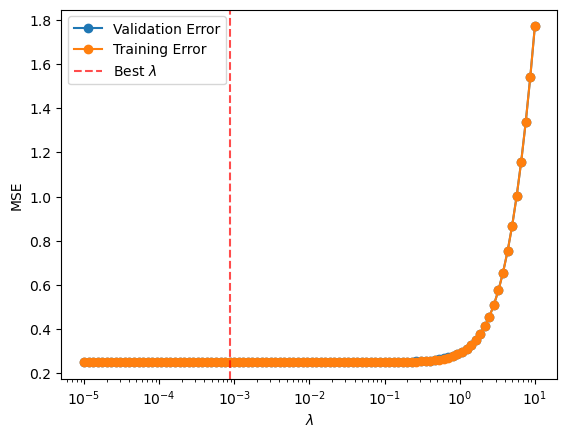

In [74]:
# Ins# Parameters for non-symmetric range
ntrain = 1000
ntest = 200
D = 1
low_D = [2] * D
high_D = [5] * D
sigma_noise = 0.5
truew = np.random.randn(D, 1)
reg_pars = np.logspace(-5, 1, 100)  # Range of regularization parameters
KF = 5  # Number of folds for cross-validation

# Generate new training and test data
Xtr, Ytr = linearRegrFunction(ntrain, D, low_D, high_D, truew, sigma_noise)
Xte, Yte = linearRegrFunction(ntest, D, low_D, high_D, truew, sigma_noise)

# Perform K-Fold CV to find the best lambda
bestlam, Vm, Vs, Tm, Ts = KFoldCVRLS(Xtr, Ytr, KF, reg_pars)

# Print the new best lambda
print("[--] Best lambda found on new dataset: {}".format(bestlam))

# Train model with the new best lambda and calculate test error
w_best = regularizedLSTrain(Xtr, Ytr, bestlam)
Ypred_best = regularizedLSTest(w_best, Xte)
test_err = calcError(Ypred_best, Yte)

print("[--] Test error on new dataset: {}".format(test_err))

# Plot training and validation errors for the new dataset
_, ax = plt.subplots()
ax.plot(reg_pars, Vm, '-o', label="Validation Error")
ax.plot(reg_pars, Tm, '-o', label="Training Error")
ax.axvline(bestlam, linestyle="--", color="red", alpha=0.7, label="Best $\lambda$")
ax.set_xscale("log")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.legend(loc="best")
plt.show()


<>:38: SyntaxWarning: invalid escape sequence '\l'
<>:39: SyntaxWarning: invalid escape sequence '\l'
<>:41: SyntaxWarning: invalid escape sequence '\l'
<>:38: SyntaxWarning: invalid escape sequence '\l'
<>:39: SyntaxWarning: invalid escape sequence '\l'
<>:41: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Somayyeh\AppData\Local\Temp\ipykernel_6044\2547917321.py:38: SyntaxWarning: invalid escape sequence '\l'
  ax.axvline(bestlam_sym, linestyle="--", color="blue", alpha=0.7, label="Best $\lambda$ (Symmetric)")
C:\Users\Somayyeh\AppData\Local\Temp\ipykernel_6044\2547917321.py:39: SyntaxWarning: invalid escape sequence '\l'
  ax.axvline(bestlam_asym, linestyle="--", color="green", alpha=0.7, label="Best $\lambda$ (Non-Symmetric)")
C:\Users\Somayyeh\AppData\Local\Temp\ipykernel_6044\2547917321.py:41: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel("$\lambda$")


[--] Best lambda on symmetric dataset: 1.747528400007683e-05
[--] Best lambda on non-symmetric dataset: 1.3219411484660286e-05


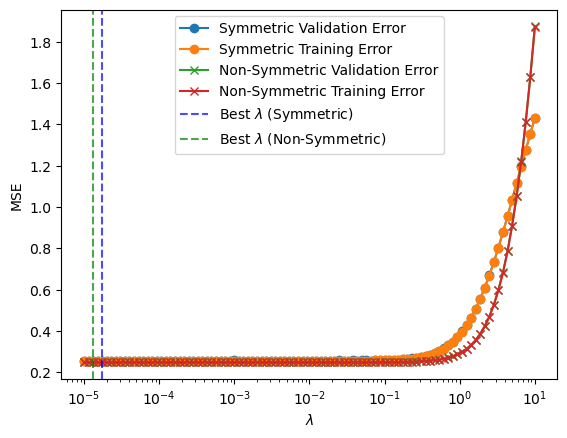

In [76]:
# Initial symmetric range parameters
ntrain = 1000
ntest = 200
D = 1
low_D_symmetric = [-3] * D
high_D_symmetric = [3] * D
sigma_noise = 0.5
truew = np.random.randn(D, 1)
reg_pars = np.logspace(-5, 1, 100)
KF = 5

# Generate the original symmetric dataset
Xtr_sym, Ytr_sym = linearRegrFunction(ntrain, D, low_D_symmetric, high_D_symmetric, truew, sigma_noise)
Xte_sym, Yte_sym = linearRegrFunction(ntest, D, low_D_symmetric, high_D_symmetric, truew, sigma_noise)

# Perform K-Fold CV on the symmetric dataset
bestlam_sym, Vm_sym, Vs_sym, Tm_sym, Ts_sym = KFoldCVRLS(Xtr_sym, Ytr_sym, KF, reg_pars)
print("[--] Best lambda on symmetric dataset: {}".format(bestlam_sym))

# Non-symmetric range parameters
low_D_asym = [2] * D
high_D_asym = [5] * D

# Generate the new non-symmetric dataset
Xtr_asym, Ytr_asym = linearRegrFunction(ntrain, D, low_D_asym, high_D_asym, truew, sigma_noise)
Xte_asym, Yte_asym = linearRegrFunction(ntest, D, low_D_asym, high_D_asym, truew, sigma_noise)

# Perform K-Fold CV on the non-symmetric dataset
bestlam_asym, Vm_asym, Vs_asym, Tm_asym, Ts_asym = KFoldCVRLS(Xtr_asym, Ytr_asym, KF, reg_pars)
print("[--] Best lambda on non-symmetric dataset: {}".format(bestlam_asym))

# Plot comparison of training and validation errors
_, ax = plt.subplots()
ax.plot(reg_pars, Vm_sym, '-o', label="Symmetric Validation Error")
ax.plot(reg_pars, Tm_sym, '-o', label="Symmetric Training Error")
ax.plot(reg_pars, Vm_asym, '-x', label="Non-Symmetric Validation Error")
ax.plot(reg_pars, Tm_asym, '-x', label="Non-Symmetric Training Error")
ax.axvline(bestlam_sym, linestyle="--", color="blue", alpha=0.7, label="Best $\lambda$ (Symmetric)")
ax.axvline(bestlam_asym, linestyle="--", color="green", alpha=0.7, label="Best $\lambda$ (Non-Symmetric)")
ax.set_xscale("log")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.legend(loc="best")
plt.show()




1**Difference in Best Lambda:
It could be that the best is different for the two datasets. That's a clue that regularization parameter may be sensitive to distribution of data. The different ranges and distributions of the features of inputs can affect how much regularization useful, perhaps enabling a different that balances bias and variance optimally.
validation and training error trends:ds**:
It can be noticed that, as the value of increases, generally, for both training datasets, the error also increases due to higher regularization leading to underfitting, while the general trend for the validation error is to follow a U-shaped curve. However, this optimum value might lie at different minimums since generalization capability varies with the range of the data and other characteristics of noise

3. **Impact of Data Range on Genera:lization
This could introduce feature scaling shifts due to the nonsymmetric data range that may necessitate a different quantity of regularization to achieve the same generalization as in the symmetric dataset. This is because these nonsymmetric ranges or higher absolute values for features can lead to model parameters of larger magnitudes, which requires stronger regularization in order to avoid overfittRegularization Prameter sensitvity:sitivity**:
- If there is a large gap between values of, this then realizes that regularization parameters are not globally optimal across different distributions of data. That is why things like K-Fold Cross-Validation are so important in determining the most optimal for the dataset presented.

These observations illustrate how the data distribution influences the regularization needs of the model, so tf \\\\ \lambda \\\\ ) is important in each different dataset.ferent dataset.